# Homework 3 - Kaveh
Climate Modeling, ATS 421/521, Spring 2018

## Draft due May 3 (10 am); Final due May 8 (noon)

Start by specifing inline plots and import all the modules you'll need.

In [1]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Updated ERBE and NCEP datasets are used:
ERBE_PATH = './ERBE_mean_updated.cdf'
NCEP_PATH = './NCEP_mean_updated.nc'

/home/kaveh/.local/share/virtualenvs/ats521-xrSXe-P-/lib/python3.6/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


## 1.	Implement the 1D-EBM in a Python program. 

*	Set up a grid from 90ºS to 90ºN with N=18 boxes and $\Delta \phi$=10º. [Note: next week, you will increasing the resolution (grid spacing), so you may want to make it easy to modify this.]


*	Use zero meridonal heat flux at the poles ($F_{m,1}$=$F_{m,N+1}$=0) as boundary conditions. 


*	Use K($\tilde{\phi}$)=K$_0$cos($\tilde{\phi}$), with K$_0$=2×10$^5$ m$^2$s$^{-1}$ for the diffusivity,  


*	The **new** albedo parameter values (T$_L$=255 K, T$_U$=293 K, α$_{max}$=0.64, and α$_{min}$=0.25), 


*	OLR (A+BT, with A=-244 Wm$^{-2}$, B=1.66 Wm$^{-2}$K$^{-1}$), and 


*	Incoming solar radiation parameterizations (295 Wm⁻² +125 cos(2$\phi$) Wm⁻²) as given in Lecture 4. 


Initialize the model with T=293 K everywhere, and run the model **to equilibrium**.	


In [2]:
heat_capacity = 2.2 * 10 ** 8     # Heat capacity of water (oceans) and air (J/(m2.K))
earth_radius = 6371 * 1000        # Earth radius in meters

albedo_min=0.25
albedo_max=0.64
temperature_upper=293
temperature_lower=255
m = (albedo_max - albedo_min) / (temperature_upper - temperature_lower)    # Slope of albedo function (a(t))

def create_grids(delta_lat):
    """ Creates 2 grids with intervals of `delta_lat`.
    The first grid is edges and the second one is cells """
    return np.linspace(-90, 90, 1 + 180 / delta_lat), np.linspace(-85, 85, 180 / delta_lat)

def lat_circumference(lat_rad):
    """ Calculates circumference at a given latitude """
    return 2 * np.pi * earth_radius * np.cos(lat_rad)    # m

def lat_band_area(lat_rad_1, lat_rad_2):
    """ Calculates surface area of a latitude band between `lat_rad_1` and `lat_rad_2` """
    return 2 * np.pi * earth_radius ** 2 * (np.sin(lat_rad_1) - np.sin(lat_rad_2))    # m2

def albedo(temperature):
    """ calculates albedo using a given temperature """
    if temperature < temperature_lower:
        return albedo_max
    elif temperature > temperature_upper:
        return albedo_min
    else:
        return albedo_min + m * (temperature_upper - temperature)


def k(lat_rad):
    """ Calculates diffusivity for a given latitude (radian) """
    return np.cos(lat_rad) * 2 * 10 ** 5


def f_m_j(delta_temp, delta_lat_rad, lat_rad):
    """ Calculates heat flux density at a given latitude (radian)
        `delta_temp` and `delta_lat_rad` are differences between temperature and latitude of two adjucent cells.
    """
    return (-heat_capacity * k(lat_rad) / earth_radius) * (delta_temp / delta_lat_rad)    # W/m


def solar_radiation(lat_rad):
    """ Calculates incoming solar radiation at a given latitude (radian) """
    return 295 + 125 * np.cos(2 * lat_rad)    # W/m2


def olr_lw_feedback(temperature):
    """ Calculates outgoing longwave radiation for a give temperature (K) """
    return -244 + 1.66 * temperature    # W/m2


def asr(cell_albedo, lat_rad):
    """ Calculates absorbed solar radiation at a given latitude (radian) using the cell albedo """
    return (1 - cell_albedo) * solar_radiation(lat_rad)    # W/m2


def calculate_temperature(
    init_temperature,
    cells,
    edges,
    delta_lat,
    delta_time=10,
    ignore_meridional_flux=False
):
    """ Calculates equilibrium temperature.
    
    Input arguments:
        - int_temperatures: K
        - cells: list of cell latitudes
        - edges: list of edge latitudes, corresponding to `cells`
        - delta_lat: latitude interval between cells (and edges)
        - delta_time: time step preiod in days (default: 10 days)
        - ignore_meridional_flux: if set to True, the function doesn't consider meridional flux for calculating equilibrium temperature
    
    Returns a tuple of five items:
        - cells_temperatures: K
        - cells_albedo
        - cells_asr: W/m2
        - cells_olr: W/m2
        - edges_meridional_flux_density: W/m
    """
    delta_time = delta_time * 86400     # convert days to seconds
    delta_lat_rad = np.radians(delta_lat)
    cells_rad = np.radians(cells)
    edges_rad = np.radians(edges)
    
    cells_albedo = np.zeros(len(cells))
    cells_asr = np.zeros(len(cells))
    cells_olr = np.zeros(len(cells))
    cells_meridional_flux = np.zeros(len(cells))
    edges_meridional_flux_density = np.zeros(len(edges))
    edges_meridional_flux_density[0] = edges_meridional_flux_density[-1] = 0
    cells_temperatures = np.full(len(cells), init_temperature)

    for i in range(3000):
        for idx, cell_lat_rad in enumerate(cells_rad):
            cell_temperature = cells_temperatures[idx]
            
            cells_albedo[idx] = albedo(cell_temperature)
            cells_asr[idx] = asr(cells_albedo[idx], cell_lat_rad)
            cells_olr[idx] = olr_lw_feedback(cell_temperature)
        for j in range(1, len(cells_rad)):
            edges_meridional_flux_density[j] = f_m_j(cells_temperatures[j] - cells_temperatures[j-1], delta_lat_rad, edges_rad[j])
        for idx, cell_lat_rad in enumerate(cells_rad):
            radiative_flux = cells_asr[idx] - cells_olr[idx]
            if not ignore_meridional_flux:
                cells_meridional_flux[idx] = (np.cos(edges_rad[idx+1]) * edges_meridional_flux_density[idx+1] - np.cos(edges_rad[idx]) * edges_meridional_flux_density[idx]) / delta_lat_rad
                radiative_flux += -cells_meridional_flux[idx] / (earth_radius * np.cos(cell_lat_rad))
            cells_temperatures[idx] = cells_temperatures[idx] + radiative_flux * delta_time / heat_capacity

    return cells_temperatures, cells_albedo, cells_asr, cells_olr, edges_meridional_flux_density

init_temp = 293    # K
delta_lat = 10     # Degree

edges_grid, cells_grid = create_grids(delta_lat)    # Create edge and cell grids from 90S to 90N with intervals of 10 degree

cells_temp, cells_albedo, cells_asr, cells_olr, edges_meridional_flux_density = calculate_temperature(
    293, cells_grid, edges_grid, delta_lat
)
T = cells_temp
MHF = edges_meridional_flux_density

/home/kaveh/.local/share/virtualenvs/ats521-xrSXe-P-/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


Plot the simulated distributions of equilibrium temperature T, incoming solar radiation, planetary albedo α, absorbed solar radiation, outgoing longwave radiation, meridional heat flux density F$_m$, and total meridional heat transport.

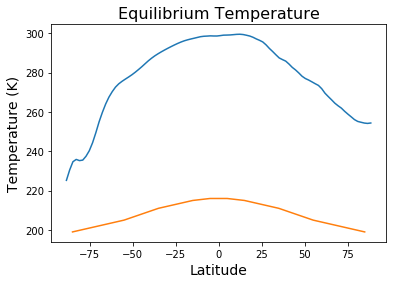

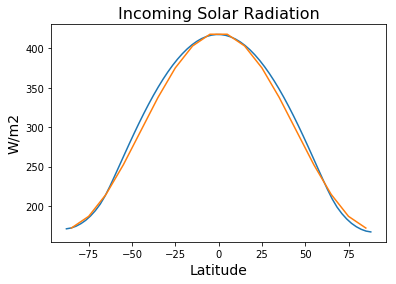

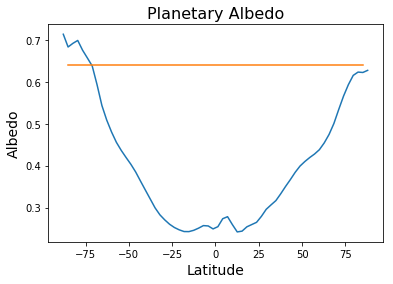

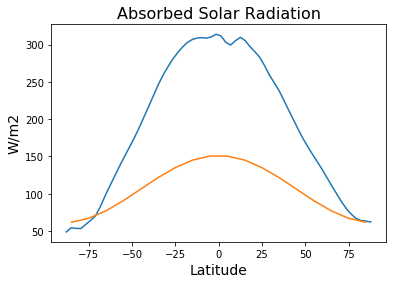

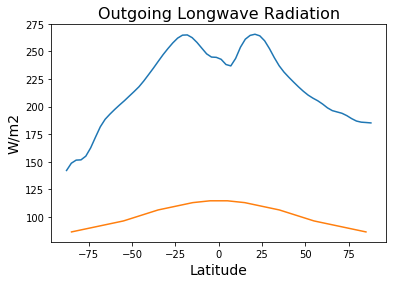

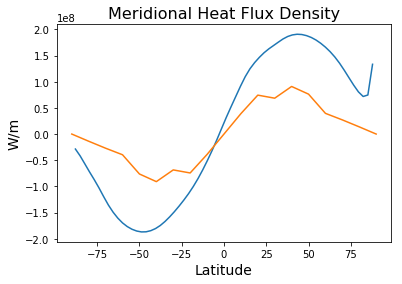

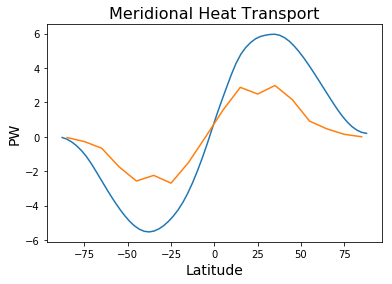

In [3]:
with xr.open_dataset(NCEP_PATH) as ncep:
    ncep_avg = ncep.mean('LON')    # Zonally averaged (over longitude)

    plt.title('Equilibrium Temperature', fontsize=16)
    plt.xlabel('Latitude', fontsize=14)
    plt.ylabel('Temperature (K)',fontsize=14)
    plt.plot(ncep_avg.LAT, ncep_avg.T2 + 273.15)
    plt.plot(cells_grid, cells_temp)
    plt.show()

with xr.open_dataset(ERBE_PATH) as erbe:
    erbe_avg = erbe.mean('LON')    # Zonally averaged (over longitude)

    plt.title('Incoming Solar Radiation', fontsize=16)
    plt.xlabel('Latitude', fontsize=14)
    plt.ylabel('W/m2',fontsize=14)
    plt.plot(erbe_avg.LAT, erbe_avg.SOLAR)
    plt.plot(cells_grid, solar_radiation(np.radians(cells_grid)))
    plt.show()

    plt.title('Planetary Albedo', fontsize=16)
    plt.xlabel('Latitude', fontsize=14)
    plt.ylabel('Albedo', fontsize=14)
    # Albedo formula comes from this: ASR = (1 - albedo) * solar_radiation(lat)
    plt.plot(erbe_avg.LAT, 1 - (erbe_avg.ASR / erbe_avg.SOLAR))
    plt.plot(cells_grid, cells_albedo)
    plt.show()

    plt.title('Absorbed Solar Radiation', fontsize=16)
    plt.xlabel('Latitude', fontsize=14)
    plt.ylabel('W/m2',fontsize=14)
    plt.plot(erbe_avg.LAT, erbe_avg.ASR)
    plt.plot(cells_grid, cells_asr)
    plt.show()

    plt.title('Outgoing Longwave Radiation', fontsize=16)
    plt.xlabel('Latitude', fontsize=14)
    plt.ylabel('W/m2',fontsize=14)
    plt.plot(erbe_avg.LAT, erbe_avg.OLR)
    plt.plot(cells_grid, cells_olr)
    plt.show()

    # Calculate surface area between edges (m2)
    bands_surface_areas = 2 * np.pi * (earth_radius ** 2) * np.diff(np.sin(np.radians(erbe.LATedges)))
    meridional_heat_transport = np.cumsum(erbe_avg.NET * bands_surface_areas)
    
    plt.title('Meridional Heat Flux Density', fontsize=16)
    plt.xlabel('Latitude', fontsize=14)
    plt.ylabel('W/m',fontsize=14)
    plt.plot(erbe_avg.LAT, meridional_heat_transport / lat_circumference(np.radians(erbe_avg.LAT)))
    plt.plot(edges_grid, edges_meridional_flux_density)
    plt.show()

    plt.title('Meridional Heat Transport', fontsize=16)
    plt.xlabel('Latitude', fontsize=14)
    plt.ylabel('PW',fontsize=14)
    plt.plot(erbe_avg.LAT, meridional_heat_transport / 10 ** 15)
    plt.plot(cells_grid, edges_meridional_flux_density[1:] * lat_circumference(np.radians(cells_grid)) / 10 ** 15)
    plt.show()

## 2.	Using the netcdf data files ERBE_mean.cdf and ncep.mean.nc, which contain ERBE satellite data of TOA fluxes and NCEP surface temperatures, respectively: 

a)	Calculate the zonally averaged values of 2-meter temperature T (from the NCEP data). Plot these values on the same plot as your model's equilibrium temperature. 

In [4]:
# Your plot here, or include it in Question 1 plot.

b)	Calculate the zonally averaged incoming solar radiation, planetary albedo α, absorbed solar radiation, outgoing longwave radiation, meridional heat flux density F$_m$, and total meridional heat transport. Plot these values along with the corresponding values from your model. 

In [5]:
# Your plots here, or include ERBE/NCEP data in Question 1 plots. 
# [Please keep your plots in this order for easier grading.]

c)	For **each** plot, how well does the model compare to the observations?  Describe the two lines (as if you were describing them to someone not looking at the plot).  In which ways are they similar; in which ways are they different?

d) Speculate about why these differences may exist, based on what you know about the climate system.  Which processes are missing in our model that may be responsible? [I'm not interested in a specific answer here, just that your reasoning is consistent.]

### Equilibrium Temperature:

  Both the model and observation follow a bell curve, though the model is symmetrical while observation has some changes at different latitudes. Minimum values are at the poles and maximum value happens at the equator. The temperature range is between ~250K to ~300K.
    There is a big gap at lower latitudes close to the south pole between the model and observation. Observed temperature at the south pole is more than 20K less than results of the model. High elevation and more land ice in the south pole can be causes of this lower observed temperature. Also there is less land mass and more ocean water in the southern hemisphere; heat capacity of ocean water is less than land and it contributes to lower temperature in southern parts close to Antarctica.
    
### Incoming Solar Radiation:

    In this case model results almost match the observation. ISR plot is a bell curve with maximum value at the equator and minimum values at the poles. Its range goes from ~160 W/m2 to ~410 W/m2.
    Incoming solar radiation does not depend on many factors within the climate system and is predictable at different latitudes. It gives us a formula that fits observation almost perfectly.

### Planetary Albedo and Absorbed Solar Radiation (ASR):

    Observed albedo is calculated using observed ASR and discrepancies in ASR are reflected in albedo too. Changes in albedo are opposite of changes in ASR; i.e. higher albedo results in less ASR and vice versa. 
    Albedo values follow an upside-down bell curve with maximum values occurring at the poles and minimum values occurring at the equator. Generally observed albedo is bigger than what is used in our model. It can be due to topographic differences at different latitudes. There is also a bump in albedo around the equator. It probably is due to albedo of clouds at those latitudes. Albedo starts at ~0.7 around south pole and goes down to ~0.25 at the equator and then rises again to ~0.6 as we go north towards the pole. Albedo at south pole is higher compared to north because south pole has more land ice compared to the sea ice at the north pole.
    As for ASR, the bell curve shows a range of values from minimum ~50 W/m2 at the poles and maximum ~310 W/m2 at the equator. At the same latitudes that albedo shows a bump around the equator, ASR drops down a bit.

### Outgoing Longwave Radiation (OLR):

    OLR plot is a bell curve also. In the model, values range start from ~170 W/m2 at the poles and goes up to ~250 W/m2 at the equator.
    Observed OLR has a higher range, which is between ~140 W/m2 and 265 W/m2. At south and north of equator, there are two jumps in value of observed OLR and it surpasses the model, while it drops down to ~235 W/m2 at the equator. The two bumps around the equator can be due to extensive area of desert land at those latitude bands. There are also more clouds at the equator which decrease outgoing radiations.

### Meridional Heat Flux Density and Heat Transport:

    Both the observations and model results follow a sine wave. Values are zero at the poles and the equator. As we start moving north from the south pole, their values drop and then turns around at ~45 degree south and starts rising to their maximum value at ~45 degree north. Minimum and maximum values are about -2e8 and +2e8 W/m for heat flux density and about -6 and +6 PW for heat transport.
    Meridional Heat Flux, which is calculated using ERBE observations, shows a sudden increase around north pole. This increase is due to accumulation of errors coming from previous cells. As we iterate through the grid for calculating density, the errors from previous cells add up and show up at the final cell, around the north pole. If we start our iteration from northern latitudes, the error shows up at lower latitudes, around the south pole.

## 3. ATS 521 only:

Choose two parameters ("constants") in the model. Can you tune the model (alter these parameters) to improve its performance compared to the observations? For each of the two parameters, pick 3-5 different values, and plot the temperature distributions on a single plot.  What would these changes in parameters correspond to physically?

In [ ]:
# Your code here.

_Your answers for 3 can go in this markdown cell._

## Checklist

* Notebook re-runs correctly ("Kernel" -> "Restart and run all" works).
* All variables are commented with short variable decription (if not obvious from variable name) and units.
* Any functions include docstrings or sufficient commenting to describe inputs, outputs, and what it does.
* Include sufficient commenting in code that someone could look at portions and easily understand your methodology.
* Plots include titles, labels (with units) on x and y axes, and legends (if multiple lines). (Titles/legends are not necessary if they convey no more information than x and y axis labels.)
* Numerical values in Markdown or print statements include units.
* Answers to “compare,” “explain,” etc. questions are in complete sentences and grammatically correct. 